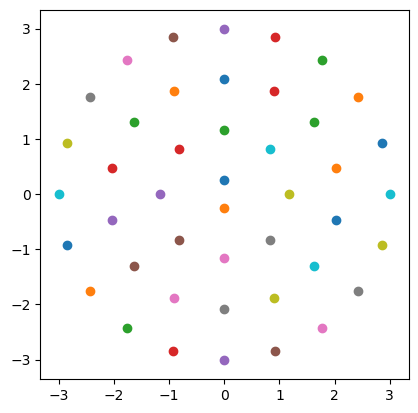

number of points: 44
number of sims: 30976


In [11]:
#Tweak directCollocation
from IPython.display import HTML
from collections import namedtuple
from multiprocessing import Pool
from tqdm.notebook import tqdm
import csv
import numpy as np
import math
from typing import Dict
from pydrake.all import (MultibodyPlant, Parser, RigidTransform, DirectCollocation)
import acrobot, acrobot_sim, visualizer, environment, controllers
import path_planner,trajectory_optimization, plot_maker, analysis
import importlib
importlib.reload(acrobot)
importlib.reload(acrobot_sim)
importlib.reload(visualizer)
importlib.reload(environment)
importlib.reload(controllers)
importlib.reload(path_planner)
importlib.reload(trajectory_optimization)
importlib.reload(plot_maker)
importlib.reload(analysis)
from acrobot_sim import simulate_acrobot
from acrobot import Acrobot
from visualizer import AcrobotVisualizer, create_animation
from environment import Environment
from controllers import *
from path_planner import TrivialPathPlanner, AStarPathPlanner
from trajectory_optimization import DirectCollocationParameters, DirectCollocationTrajectoryGenerator
from plot_maker import *
from analysis import *

plant = MultibodyPlant(time_step=0)
parser = Parser(plant)
parser.AddModels("acrobot.urdf")
plant.WeldFrames(
    plant.world_frame(),
    plant.GetBodyByName("base").body_frame(),
    RigidTransform.Identity()
)
plant.Finalize()

bot = Acrobot(plant)
env = Environment(-3, 3, -3, 3, 0.01, (0,0))

# Start and Goal states
SimParams = namedtuple('SimParams', ['start_pos', 'goal_pos', 'time_cost','input_cost'])

def plan_trajectory(params:SimParams):
    opts = DirectCollocationParameters()
    traj_opt = DirectCollocationTrajectoryGenerator(bot, opts)
    traj_opt.params.time_cost = params.time_cost
    traj_opt.params.R = params.input_cost

    start_state = np.hstack((bot.get_joint_angles(params.start_pos,(params.start_pos[0] > 0)),np.zeros(2)))
    time = -1
    if any([math.isnan(start_state[0]),math.isnan(start_state[1])]):
        print("bad start_state from: {}".format(params.start_pos))
        effort = -3
    else:
        try:
            sol = traj_opt.generate_trajectory(start_state, params.goal_pos)
            if sol.is_success():
            # x_traj = traj_opt.collocation_prog.ReconstructStateTrajectory(sol)
                u_traj = traj_opt.collocation_prog.ReconstructInputTrajectory(sol)

                # trajectories:Dict[int,PiecewisePolynomial] = {1:x_traj, 2:u_traj}
                effort = get_total_effort(u_traj, 1)
                time = u_traj.end_time()
            else:
                effort = -1
        except:
            effort = -2
            # print("bad sim: {}".format(params))

    return np.array([params.start_pos[0], params.start_pos[1], params.goal_pos[0],
                     params.goal_pos[1], params.time_cost, params.input_cost, time, effort])



def circle_points(r):
    circles = []
    for r in r:
        n = math.ceil(20*r/3)
        # n = math.ceil(10*r/3)
        t = np.linspace(-np.pi, np.pi, n, endpoint=False)
        for t in t:
            x = r * np.sin(t)
            y = -(r * np.cos(t))
            circles.append([x, y])
    return circles

# circles = circle_points(np.linspace(0.01,3,1))
circles = circle_points(np.linspace(0.25,3,4))
fig, ax = plt.subplots()
for circle in circles:
    ax.scatter(circle[0], circle[1])
ax.set_aspect('equal')
plt.show()


print("number of points: {}".format(len(circles)))


effort = 0
results = []
i = 0
inputs = []
file = open(r'parallel_collocation_suite_results2.csv', 'a')

for start_pos in circles:
    # print("start: {}".format(start_pos))
    for goal_pos in circles:
        # print("goal: {}".format(goal_pos))
        for time_cost in np.logspace(0,2,4,base=10):
            for input_cost in np.logspace(0,2,4,base=10):
                
                params =  SimParams(start_pos, goal_pos, time_cost, input_cost)
                inputs.append(params)
                # Set up DirectCollocation
                    

print("number of sims: {}".format(len(inputs)))
with file:
    write = csv.writer(file)
    write.writerow(["start_x", "start_y", "goal_x","goal_y","time_cost","input_cost","time","effort"])
    with Pool() as pool:
        for x in pool.map(plan_trajectory, inputs):
            results.append(x)
            write.writerow(x)
    
    

    # for row in results:
        

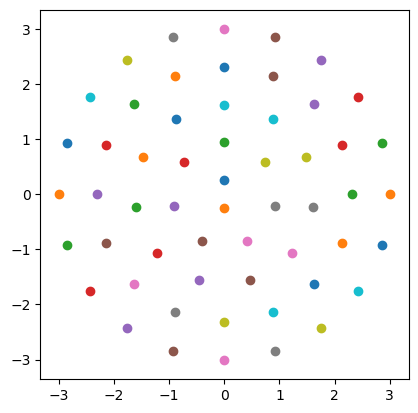

number of points: 56


In [9]:
def circle_points(r):
    circles = []
    for r in r:
        n = math.ceil(20*r/3)
        # n = math.ceil(10*r/3)
        t = np.linspace(-np.pi, np.pi, n, endpoint=False)
        for t in t:
            x = r * np.sin(t)
            y = -(r * np.cos(t))
            circles.append([x, y])
    return circles

# circles = circle_points(np.linspace(0.01,3,1))
circles = circle_points(np.linspace(0.25,3,5))
fig, ax = plt.subplots()
for circle in circles:
    ax.scatter(circle[0], circle[1])
ax.set_aspect('equal')
plt.show()


print("number of points: {}".format(len(circles)))